In [18]:
# Import libraries
import os
import sys
import pandas as pd
import numpy as np
import comtypes.client
import ctypes

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pathlib import Path
from dotenv import load_dotenv

In [19]:
# Import custom utils
from utils import *

# Basic parameters

In [20]:
g = 9.8067  # m/s²
code = "NSR-10"
soil = "E"
use_group = "I"
importance_factor = coef_import(use_group)
Aa = 0.25
Av = 0.20
spectrum_name = "Test Spectrum"
R = 7
H_total = 8.1  # m

# Spectrum according to NSR-10

In [21]:
load_dotenv()
excel_path = os.getenv("EXCEL_TABLES_PATH")

df_Fa = pd.read_excel(excel_path, sheet_name="Tabla A.2.4-3_Fa", index_col=0)
df_Fv = pd.read_excel(excel_path, sheet_name="Tabla A.2.4-4_Fv", index_col=0)

Fa = df_Fa.loc[soil, Aa]
print(f'Fa: {Fa}')
Fv = df_Fv.loc[soil, Av]
print(f'Fv: {Fv}')

T0 = 0.10 * (Av*Fv)/(Aa*Fa)
Tc = 0.48 * (Av*Fv)/(Aa*Fa)
Tl = 2.4*Fv

Fa: 1.45
Fv: 3.2


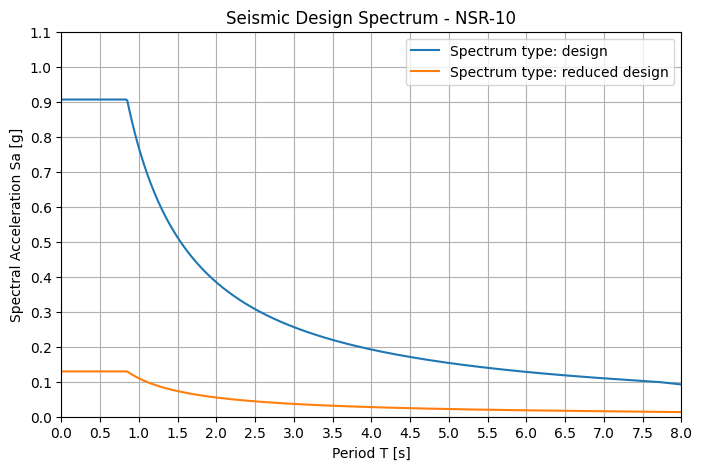

In [22]:
plt.figure(figsize=(8, 5))

T, Sa = plot_spectrum(
    Aa, Av, Fa, Fv, T0, Tc, Tl, importance_factor, 1, spectrum_type="design"
)
T, Sa_diseno = plot_spectrum(
    Aa, Av, Fa, Fv, T0, Tc, Tl, importance_factor, R, spectrum_type="reduced design"
)

plt.xlabel("Period T [s]")
plt.ylabel("Spectral Acceleration Sa [g]")
plt.title("Seismic Design Spectrum - NSR-10")
plt.grid(True)
plt.legend()
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.5))
plt.xlim(0, 8)
plt.ylim(0, 1.1)
plt.show()

T_Sa_df = pd.DataFrame({"T": T, "Sa": Sa, "Sa_diseno": Sa_diseno})

In [23]:
Ta_df = pd.read_excel(excel_path, sheet_name="Sistema estructural", index_col=0)

Sistema_estructural = "Pórticos de Concreto Resistente a Momento"
Ct = Ta_df.loc[Sistema_estructural, 'Ct']
a = Ta_df.loc[Sistema_estructural, 'a']

Ta = float(Ct * (H_total ** a))
Cu = max(1.2, 1.75-1.2*Av*Fv)
CuTa = Cu * Ta

# Model
Initalize Etabs model

In [24]:
# Basic options to control ETABS instance

# ETABS model name
ModelName = "Test.EDB"

AttachToInstance = True  # False si el programa no está abierto

# Con respecto a qué instancia de ETABS usar
SpecifyPath = False
ProgramPath = R"C:\Program Files\Computers and Structures\ETABS 22\ETABS.exe"

APIPath = os.getenv("API_PATH")

if not os.path.exists(APIPath):
    try:
        os.makedirs(APIPath)
    except OSError:
        pass

ModelPath = APIPath + os.sep + ModelName

# create API helper object
helper = comtypes.client.CreateObject("ETABSv1.Helper")
helper = helper.QueryInterface(comtypes.gen.ETABSv1.cHelper)

if AttachToInstance:
    # attach to a running instance of ETABS
    try:
        # get the active ETABS object
        myETABSObject = helper.GetObject("CSI.ETABS.API.ETABSObject")
    except (OSError, comtypes.COMError):
        print("No running instance of the program found or failed to attach.")
        sys.exit(-1)
else:
    if SpecifyPath:
        try:
            #'create an instance of the ETABS object from the specified path
            myETABSObject = helper.CreateObject(ProgramPath)
        except (OSError, comtypes.COMError):
            print("Cannot start a new instance of the program from " + ProgramPath)
            sys.exit(-1)
    else:
        try:
            # create an instance of the ETABS object from the latest installed ETABS
            myETABSObject = helper.CreateObjectProgID("CSI.ETABS.API.ETABSObject")
        except (OSError, comtypes.COMError):
            print("Cannot start a new instance of the program.")
            sys.exit(-1)

    # start ETABS application
    myETABSObject.ApplicationStart()

# create SapModel object
SapModel = myETABSObject.SapModel

# initialize model
kN_m_C = 6  # Units kN, m, C
kgf_m_C = 8  # Units kgf, m, C
Ton_m_C = 12  # Units Ton, m, C
ret = SapModel.SetPresentUnits(kN_m_C)
presentUnits = SapModel.GetPresentUnits()

ETABS functions

In [25]:
def select_all_cases_and_combos():
    ret = SapModel.Results.Setup.DeselectAllCasesAndCombosForOutput()
    ret, case_names, _ = SapModel.LoadCases.GetNameList()
    ret, combo_names, _ = SapModel.RespCombo.GetNameList()

    for case_name in case_names:
        ret = SapModel.Results.Setup.SetCaseSelectedForOutput(case_name, Selected = True)

    for combo_name in combo_names:
        ret = SapModel.Results.Setup.SetComboSelectedForOutput(combo_name, Selected = True)

def save_and_unlock():
    ret = SapModel.SelectObj.All()
    ret = SapModel.File.Save(ModelPath)
    ret = SapModel.SetModelIsLocked(False)
    
def run_analysis():
    ret = SapModel.SelectObj.All()
    ret = SapModel.File.Save(ModelPath)
    ret = SapModel.Analyze.RunAnalysis()
    select_all_cases_and_combos()

def extract_values(name):
    select_all_cases_and_combos()
    table = SapModel.DatabaseTables.GetTableForDisplayArray(name, GroupName="")
    df = pd.DataFrame(np.array_split(table[4], table[3]))
    df.columns = table[2] # Ajustar los nombres de las columnas
    return df

Upload seismic spectrum to ETABS models

In [26]:
ret = SapModel.Func.GetNameList()
original_functions = list(ret[1]) + ([spectrum_name])
# print(original_functions)

save_and_unlock()

ret = SapModel.Func.GetNameList()

if spectrum_name in ret[1]:
    print(f"El espectro '{spectrum_name}' ya existe.")

else:
    T_values = T_Sa_df['T'].values
    Sa_values = T_Sa_df['Sa_diseno'].values

    periods, accelerations = zip(*sorted(zip(T_values, Sa_values)))

    # ✅ Delete it first if it already exists
    num_names, name_array, _ = SapModel.Func.GetNameList()

    db_tables = SapModel.DatabaseTables
    table_key = "Functions - Response Spectrum - User Defined"

    # ✅ Correct field list (NO GUID COLUMN)
    fields = ["Name", "Period", "Value", "DampingRatio"]

    # Build rows
    table_data = [
        [spectrum_name, str(period), str(accel), "0.05"]
        for period, accel in zip(periods, accelerations)
    ]

    # Flatten data
    flattened_data = [item for row in table_data for item in row]

    # ✅ Correct version number = 0
    ret02 = db_tables.SetTableForEditingArray(
        table_key,
        1,                  # <-- MUST BE ZERO
        fields,
        len(table_data),
        flattened_data
    )

    ret03 = db_tables.ApplyEditedTables(True)

    ret = SapModel.Func.GetNameList()
    new_functions = list(ret[1]) if (ret and len(ret) > 1 and ret[1] is not None) else []

    to_delete = [f for f in new_functions if f not in original_functions]
    for name in to_delete:
        SapModel.Func.Delete(name)
        
    # refresh after deletions
    ret = SapModel.Func.GetNameList()
    new_functions = list(ret[1]) if (ret and len(ret) > 1 and ret[1] is not None) else []
    # print("Remaining functions:", new_functions)

El espectro 'Test Spectrum' ya existe.


Default values for seismic cases SX and SY

In [27]:
ret = SapModel.LoadCases.ResponseSpectrum.SetLoads(
    "SX",
    1,
    ("U1",),
    (spectrum_name,),
    (g,),  # SF
    ("Global",),  # CSys
    (0.0,),  # Ang
)

ret = SapModel.LoadCases.ResponseSpectrum.SetLoads(
    "SY",
    1,
    ("U2",),
    (spectrum_name,),
    (g,),  # SF
    ("Global",),  # CSys
    (0.0,),  # Ang
)

### First analysis run
To get masses, periods, and base forces 

In [28]:
run_analysis()

Model masses

In [29]:
table_mass = "Story Forces"
table_mass_df = extract_values(table_mass)
table_mass_df = table_mass_df[
    (table_mass_df["Location"] == "Bottom") & (table_mass_df["OutputCase"] == "MASA")
].reset_index(drop=True)

table_mass_df = table_mass_df[["Story", "P"]]

stories = table_mass_df["Story"].dropna().unique().tolist()
print("Model stories:", stories)

# Ensure P is numeric
table_mass_df["P"] = pd.to_numeric(table_mass_df["P"], errors="coerce")

# Calculate P_i as desired
table_mass_df["Mass_i"] = table_mass_df["P"].diff()
table_mass_df.loc[0, "Mass_i"] = table_mass_df.loc[0, "P"]

table_mass_df

Model stories: ['N+08.10', 'N+05.00']


,Story,P,Mass_i
0,N+08.10,3072.9181,3072.9181
1,N+05.00,6818.6868,3745.7687


Modal Participating Mass Ratios

In [30]:
table_periods = "Modal Participating Mass Ratios"
table_periods_df = extract_values(table_periods)
table_periods_df = table_periods_df[["Mode", "Period", "SumUX", "SumUY"]]
table_periods_df.head()

,Mode,Period,SumUX,SumUY
0,1,0.429,1.377E-06,0.9205
1,2,0.375,0.9292,0.9205
2,3,0.307,0.9395,0.9207
3,4,0.179,0.9396,0.9207
4,5,0.16,0.9403,0.9207


In [31]:
table_periods_df["SumUX"] = pd.to_numeric(table_periods_df["SumUX"], errors="coerce")
tx_row = table_periods_df.loc[table_periods_df["SumUX"] > 0.9].iloc[0]
tx = float(tx_row["Period"])

table_periods_df["SumUY"] = pd.to_numeric(table_periods_df["SumUY"], errors="coerce")
ty_row = table_periods_df.loc[table_periods_df["SumUY"] > 0.9].iloc[0]
ty = float(ty_row["Period"])

Equivalent Horizontal Force 

In [32]:
tx = min(tx, CuTa)
ty = min(ty, CuTa)

Sa_x = T_Sa_df.loc[T_Sa_df['T'] >= tx, 'Sa_diseno'].iloc[0]
Sa_y = T_Sa_df.loc[T_Sa_df['T'] >= ty, 'Sa_diseno'].iloc[0]

print(f'Sa_x = {Sa_x} g')
print(f'Sa_y = {Sa_y} g')

kx = k_value(tx)
ky = k_value(ty)

FHE_df = table_mass_df.copy().drop(columns=["P"])
FHE_df["Mass_acum_i"] = FHE_df["Mass_i"].cumsum()
FHE_df["h_i"] = [8.1, 5]
FHE_df["Mass_acum_i * h_i ^ k"] = FHE_df["Mass_acum_i"] * FHE_df["h_i"]**kx

Masa_total = FHE_df["Mass_i"].sum()
Masa_factor = FHE_df["Mass_acum_i * h_i ^ k"].sum()

FHE_df["Cv"] = FHE_df["Mass_acum_i * h_i ^ k"] / Masa_factor
Cv_total = FHE_df["Cv"].sum().round(3)

if Cv_total != 1:
    print("Cv_total != 1. Please check calculations.")

Vb_X_FHE = (Sa_x * Masa_total).round(3)
Vb_Y_FHE = (Sa_y * Masa_total).round(3)

print(f'Vb_X_FHE = {Vb_X_FHE}')
print(f'Vb_Y_FHE = {Vb_Y_FHE}')

FHE_df

Sa_x = 0.90625 g
Sa_y = 0.90625 g
Vb_X_FHE = 6179.435
Vb_Y_FHE = 6179.435


,Story,Mass_i,Mass_acum_i,h_i,Mass_acum_i * h_i ^ k,Cv
0,N+08.10,3072.9181,3072.9181,8.1,24890.63661,0.421989
1,N+05.00,3745.7687,6818.6868,5.0,34093.43400,0.578011


In [33]:
coef_regularidad = 0.8
Vb_X_FHE *= coef_regularidad
print(f'Vb_X_FHE = {Vb_X_FHE.round(3)}')
Vb_Y_FHE *= coef_regularidad
print(f'Vb_Y_FHE = {Vb_Y_FHE.round(3)}')

Vb_X_FHE = 4943.548
Vb_Y_FHE = 4943.548


In [34]:
# Dynamic forces
table_base_reaction = "Base Reactions"
table_base_reaction_df = extract_values(table_base_reaction)

table_base_reaction_df = table_base_reaction_df[["OutputCase", "FX", "FY"]]
table_base_reaction_df = table_base_reaction_df[(table_base_reaction_df["OutputCase"] == "SX") | (table_base_reaction_df["OutputCase"] == "SY")].reset_index(drop=True)
table_base_reaction_df

,OutputCase,FX,FY
0,SX,5535.6044,20.5765
1,SY,20.5765,5482.6936


In [35]:
Vb_X_din = float(table_base_reaction_df.loc[table_base_reaction_df["OutputCase"] == "SX", "FX"].iloc[0])
Vb_Y_din = float(table_base_reaction_df.loc[table_base_reaction_df["OutputCase"] == "SY", "FY"].iloc[0])

factor_ajuste_X = max(1, Vb_X_FHE / Vb_X_din)
factor_ajuste_Y = max(1, Vb_Y_FHE / Vb_Y_din)

print(f"Cortante basal FHE X: {Vb_X_FHE:.2f} kN, Cortante basal dinámico X: {Vb_X_din:.2f} kN, Factor de ajuste: {factor_ajuste_X:.2f}")
print(f"Cortante basal FHE Y: {Vb_Y_FHE:.2f} kN, Cortante basal dinámico Y: {Vb_Y_din:.2f} kN, Factor de ajuste: {factor_ajuste_Y:.2f}")

"""
Todo: Translate this part
"""

Cortante basal FHE X: 4943.55 kN, Cortante basal dinámico X: 5535.60 kN, Factor de ajuste: 1.00
Cortante basal FHE Y: 4943.55 kN, Cortante basal dinámico Y: 5482.69 kN, Factor de ajuste: 1.00


'\nTodo: Translate this part\n'

Run again, with dynamic forces adjusted according to EHF.

In [36]:
save_and_unlock()

ret = SapModel.LoadCases.ResponseSpectrum.GetLoads("SX")
print(ret)

ret = SapModel.LoadCases.ResponseSpectrum.SetLoads(
    "SX",
    1,
    ('U1',),
    (spectrum_name,),
    (g*factor_ajuste_X,),  # SF
    ('Global',),  # CSys
    (0.0,),  # Ang
)

ret = SapModel.LoadCases.ResponseSpectrum.GetLoads("SX")
print(ret)

print("="*70)

ret = SapModel.LoadCases.ResponseSpectrum.GetLoads("SY")
print(ret)

ret = SapModel.LoadCases.ResponseSpectrum.SetLoads(
    "SY",
    1,
    ('U2',),
    (spectrum_name,),
    (g*factor_ajuste_Y,),  # SF
    ('Global',),  # CSys
    (0.0,),  # Ang
)

ret = SapModel.LoadCases.ResponseSpectrum.GetLoads("SY")
print(ret)

print("="*70)

[1, ('U1',), ('Test Spectrum',), (9.8067,), ('Global',), (0.0,), 0]
[1, ('U1',), ('Test Spectrum',), (9.8067,), ('Global',), (0.0,), 0]
[1, ('U2',), ('Test Spectrum',), (9.8067,), ('Global',), (0.0,), 0]
[1, ('U2',), ('Test Spectrum',), (9.8067,), ('Global',), (0.0,), 0]


### Derivas

In [37]:
run_analysis()

In [91]:
ret = SapModel.SelectObj.ClearSelection()
ret = SapModel.SelectObj.Group("Columnas")

table_drifts = "Joint Drifts"
table_drifts_df = extract_values(table_drifts)
table_drifts_df = table_drifts_df[["Story", "Label", "UniqueName", "OutputCase", "DispX", "DispY", "DriftX", "DriftY"]]
table_drifts_df = table_drifts_df[(table_drifts_df["OutputCase"] == "SX") | (table_drifts_df["OutputCase"] == "SY")].reset_index(drop=True)
table_drifts_df["Combined"] = (pd.to_numeric(table_drifts_df["DriftX"], errors="coerce")**2 + 
                                pd.to_numeric(table_drifts_df["DriftY"], errors="coerce")**2)**0.5

table_drifts_df["DriftX Check"] = np.where(pd.to_numeric(table_drifts_df["DriftX"], errors="coerce") < 0.01, "OK", "NOT OK")
table_drifts_df["DriftY Check"] = np.where(pd.to_numeric(table_drifts_df["DriftY"], errors="coerce") < 0.01, "OK", "NOT OK")
table_drifts_df["Combined Check"] = np.where(pd.to_numeric(table_drifts_df["Combined"], errors="coerce") < 0.01, "OK", "NOT OK")

table_drifts_df

,Story,Label,UniqueName,OutputCase,DispX,DispY,DriftX,DriftY,Combined,DriftX Check,DriftY Check,Combined Check
0,N+08.10,16,285,SX,0.040763,0.004719,0.005234,0.000681,0.005278,OK,OK,OK
1,N+08.10,16,285,SY,0.000547,0.050175,5.2E-05,0.007206,0.007206,OK,OK,OK
2,N+08.10,19,230,SX,0.033777,0.004837,0.004412,0.00059,0.004451,OK,OK,OK
3,N+08.10,19,230,SY,0.000656,0.050074,7.3E-05,0.007186,0.007186,OK,OK,OK
4,N+08.10,20,235,SX,0.033735,0.000295,0.004336,6.5E-05,0.004336,OK,OK,OK
5,N+08.10,20,235,SY,0.000567,0.050785,5.4E-05,0.007253,0.007253,OK,OK,OK
6,N+08.10,26,240,SX,0.033776,0.004249,0.004498,0.000554,0.004532,OK,OK,OK
7,N+08.10,26,240,SY,0.000486,0.050923,4.8E-05,0.007176,0.007176,OK,OK,OK
8,N+08.10,42,245,SX,0.036227,0.004224,0.004417,0.000556,0.004452,OK,OK,OK
9,N+08.10,42,245,SY,0.000219,0.050935,2.8E-05,0.007252,0.007252,OK,OK,OK


Verificación de irregularidades

#1. Irregularidad torsional (1aP,1bP)

In [169]:
def torsional_irregularity(load_case, labels_per_corner):
    if load_case == "SX":
        drift_direction = "DriftX"
    elif load_case == "SY":
        drift_direction = "DriftY"
    else:
        raise ValueError("load_case must be either 'SX' or 'SY'")

    table_drifts_irreg_df = table_drifts_df.copy()

    table_drifts_irreg_df = table_drifts_irreg_df[["Story", "Label", "OutputCase", "DriftX", "DriftY"]]

    table_drifts_irreg_df["DriftX"] = pd.to_numeric(table_drifts_irreg_df["DriftX"], errors="coerce")
    table_drifts_irreg_df["DriftY"] = pd.to_numeric(table_drifts_irreg_df["DriftY"], errors="coerce")

    table_drifts_irreg_df = table_drifts_irreg_df[table_drifts_irreg_df["Label"].isin(labels_per_corner)]

    irreg_table = table_mass_df.copy().drop(columns=["P", "Mass_i"])

    for story in stories:
        for i in range(len(labels_per_corner)):
            # Assign corner labels (if needed, but can be removed if not used)
            irreg_table.loc[irreg_table["Story"] == story, f"C-{i+1}"] = labels_per_corner[i]

            filtered = table_drifts_irreg_df[(table_drifts_irreg_df["Label"] == labels_per_corner[i]) & 
                                            (table_drifts_irreg_df["OutputCase"] == load_case) & 
                                            (table_drifts_irreg_df["Story"] == story)]
            
            if not filtered.empty:
                irreg_table.loc[irreg_table["Story"] == story, f"Drift_C-{i+1}"] = filtered[drift_direction].iloc[0]
            else:
                irreg_table.loc[irreg_table["Story"] == story, f"Drift_C-{i+1}"] = 0.0

    # Calculate phi for each story
    for story in stories:
        # Get drifts for this story
        drifts = []
        for i in range(len(labels_per_corner)):
            drift = irreg_table.loc[irreg_table["Story"] == story, f"Drift_C-{i+1}"].iloc[0]
            drifts.append(drift)
        
        phi_value = 1.0  # Start with no reduction
        for i in range(len(drifts)):
            j = i
            k = (i + 1) % len(drifts)  # Next corner, wrap around
            avg_adj = (drifts[j] + drifts[k]) / 2
            lim_1 = 1.2 * avg_adj
            lim_2 = 1.4 * avg_adj
            
            if drifts[j] > lim_2:
                phi_value = min(phi_value, 0.8)
            elif drifts[j] > lim_1:
                phi_value = min(phi_value, 0.9)
            # If <= lim_1, no change
        
        irreg_table.loc[irreg_table["Story"] == story, "phi"] = phi_value

    return irreg_table

In [ ]:
labels_per_corner = ["16", "48", "26", "19"]

irreg_table_sx = torsional_irregularity("SX", labels_per_corner)
irreg_table_sy = torsional_irregularity("SY", labels_per_corner)

In [171]:
irreg_table_sx

,Story,C-1,Drift_C-1,C-2,Drift_C-2,C-3,Drift_C-3,C-4,Drift_C-4,phi
0,N+08.10,16,0.005234,48,0.005230,26,0.004498,19,0.004412,1.0
1,N+05.00,16,0.004911,48,0.004916,26,0.003969,19,0.004023,1.0


In [172]:
irreg_table_sy

,Story,C-1,Drift_C-1,C-2,Drift_C-2,C-3,Drift_C-3,C-4,Drift_C-4,phi
0,N+08.10,16,0.007206,48,0.007203,26,0.007176,19,0.007186,1.0
1,N+05.00,16,0.005574,48,0.005742,26,0.005741,19,0.005565,1.0
